In [2]:
%load_ext autoreload
%autoreload 2

from glob import glob
import requests
import json
import shutil
import contextlib
import os
import yaml
import torch
import re
from pathlib import Path
from datetime import datetime, timedelta
import pandas
import numpy as np
from epiweeks import Week
import sys
sys.path.insert(0, os.path.expanduser('~/covid19-forecast-hub-evaluation'))
from evaluate_models import main, str_to_date

def next_sat(basedate):
    if basedate.weekday() >= 5:
        return 5 + 7 - basedate.weekday()
    else:
        return 5 - basedate.weekday()

def to_reichlab(df):
    df = df.reset_index().melt(id_vars=['date'], var_name='location', value_name='value')
    try:
        df = df.set_index('location').groupby([lambda x: x.split(', ')[1], 'date']).sum().reset_index()
    except Exception:
        pass
    df = df.rename(columns={'level_0': 'location', 'date': 'target_end_date'})
    basedate = df['target_end_date'].min() - timedelta(days=1)
    dfs = []
    ndays = next_sat(basedate)
    i = 1
    while df['target_end_date'].max() > basedate + timedelta(days=ndays):
        dfs.append(df[df['target_end_date'] == basedate + timedelta(days=ndays)])
        dfs[-1]['target'] = f'{i} wk ahead cum death'
        i += 1
        ndays += 7
        pass
    df = pandas.concat(dfs)
    df['type'] = 'point'
    df['location'] = df['location'].apply(lambda x: fips.get(x, None))
    df = df[~df['location'].isnull()]
    df['quantile'] = None
    df['forecast_date'] = basedate
    target_date = df['target_end_date'].iloc[0]
    return df, basedate

req = requests.get('https://gist.githubusercontent.com/wavded/1250983/raw/bf7c1c08f7b1596ca10822baeb8049d7350b0a4b/fipsToState.json')
fips = {v:k for k, v in req.json().items()}
fips['Georgia'] = fips['Geogia']

#### Evaluation  parameters

In [41]:
user = os.environ['USER']
sweep_models = [
    'YYG-ParamSearch',
    'LANL-GrowthRate',
    'UMass-MechBayes',
]
sweeps = {
    'paper_sweep': '/checkpoint/mattle/covid19/forecasts/us/2020_08_28_06_56_52',
    'new_tar': '/checkpoint/maxn/covid19/forecasts/us/2020_08_29_07_06_35',
}
for k in sweeps.keys():
    sweep_models.append(f'fair_{k}')
print(sweep_models)

['YYG-ParamSearch', 'LANL-GrowthRate', 'UMass-MechBayes', 'fair_paper_sweep', 'fair_new_tar']


#### Load and evaluate forecasts

In [58]:
forecast_hub_dir = Path(f'/private/home/{user}/covid19-forecast-hub')
ndays = 14
metric = 'rmse_deltas'

print(forecast_hub_dir)
dates = []

# load forecasts
for name, sweep in sweeps.items():
    for pth in glob(f'{sweep}/**/model_selection.json', recursive=True):
        try:
            ms = {x['name']: x['pth'] for x in json.load(open(pth))}
            job = ms[f'best_{metric}']
            forecast = pandas.read_csv(f'{job}/final_model_validation.csv', index_col='date', parse_dates=['date'])
            df, basedate = to_reichlab(forecast)
            #print(name, basedate)
            os.makedirs(f'{forecast_hub_dir}/data-processed/fair_{name}', exist_ok=True)
            df.to_csv(f'{forecast_hub_dir}/data-processed/fair_{name}/{basedate.date()}_forecast.csv', index=False)
            dates.append(basedate)
        except Exception as e:
            print(e)

if os.path.exists('.tmp-eval'):
    shutil.rmtree('.tmp-eval')
os.makedirs('.tmp-eval')

# evaluate forecasts
for date in set(dates):
    end = date.date() + timedelta(days=next_sat(date) + ndays)    
    while end > datetime.today().date():
        end -= timedelta(days=7)
    with contextlib.redirect_stdout(None), contextlib.redirect_stderr(None):
        res = main(
            forecast_hub_dir, 
            proj_date=date.date(),
            eval_date=end,
            out_dir='.tmp-eval',
            use_cumulative_deaths=True,
        )

/private/home/maxn/covid19-forecast-hub


#### Forecast quality

In [63]:
dfs = []
for f in glob('.tmp-eval/**/*states_abs_errs.csv', recursive=True):
    date = re.search('(.*)_states', os.path.basename(f)).group(1)
    df = pandas.read_csv(f, index_col=0)
    df['date'] = date
    dfs.append(df.reset_index())
df = pandas.concat(dfs)
df = df.rename(columns={'index': 'model'})
piv = df.set_index('model').loc[sweep_models].reset_index().pivot(index='date', columns='model', values='mean')
piv.style.apply(lambda x: ["background: RoyalBlue" if v == x.min() else "" for v in x], axis = 1)

model,LANL-GrowthRate,UMass-MechBayes,YYG-ParamSearch,fair_new_tar,fair_paper_sweep
date,,,,,
2020-05-03_2020-05-23,159.000000,242.200000,122.300000,208.200000,177.000000
2020-05-18_2020-06-06,111.100000,nan,105.100000,247.500000,75.700000
2020-05-24_2020-06-13,106.700000,100.300000,122.000000,111.100000,89.600000
2020-06-08_2020-06-27,122.800000,nan,103.000000,118.300000,104.000000
2020-06-14_2020-07-04,118.500000,104.900000,122.500000,207.300000,93.200000
2020-06-21_2020-07-11,128.700000,140.600000,117.400000,212.000000,81.600000
2020-06-24_2020-07-11,123.000000,nan,119.500000,130.800000,76.300000
2020-06-29_2020-07-18,115.300000,nan,101.600000,271.100000,116.300000
2020-07-06_2020-07-25,144.900000,nan,135.700000,292.400000,155.600000


In [55]:
df = pandas.concat([piv.mean().sort_values(), piv.median().sort_values()], axis=1)
df.columns = ['mean', 'median']
df

,mean,median
fair_paper_sweep,103.64,91.40
YYG-ParamSearch,114.09,118.45
LANL-GrowthRate,127.00,122.90
UMass-MechBayes,147.00,122.75
fair_new_tar,195.90,210.10


In [40]:
dfs = []
for f in glob('.tmp-eval/**/*states_mean_ranks.csv', recursive=True):
    date = re.search('(\d+-\d+-\d+)_\d+', os.path.basename(f)).group(1)
    enddate = re.search('(\d+-\d+-\d+)_state', os.path.basename(f)).group(1)
    df = pandas.read_csv(f, index_col=0)
    df['date'] = date
    df['end_date'] = enddate
    df['mean_rank_pct'] = df['mean_rank'] / len(df)
    display(df)
    dfs.append(df.reset_index())

df_all = pandas.concat(dfs)
df_all = df_all.rename({'index': 'model'})
grouped = df_all.groupby('index').agg({'mean_rank_pct': 'mean', 'date': 'count'}).sort_values(by='mean_rank_pct')

grouped.loc[sweep_models].sort_values(by='mean_rank_pct')

,mean_rank,date,end_date,mean_rank_pct
LANL-GrowthRate,3.0,2020-06-24,2020-07-11,0.60
YYG-ParamSearch,3.0,2020-06-24,2020-07-11,0.60
fair_new_tar,3.0,2020-06-24,2020-07-11,0.60
IHME-CurveFit,3.1,2020-06-24,2020-07-11,0.62
fair_paper_sweep,3.1,2020-06-24,2020-07-11,0.62


,mean_rank,date,end_date,mean_rank_pct
fair_paper_sweep,5.7,2020-06-21,2020-07-11,0.407143
LANL-GrowthRate,6.3,2020-06-21,2020-07-11,0.450000
YYG-ParamSearch,6.4,2020-06-21,2020-07-11,0.457143
Auquan-SEIR,6.5,2020-06-21,2020-07-11,0.464286
Covid19Sim-Simulator,6.6,2020-06-21,2020-07-11,0.471429
UMass-MechBayes,6.7,2020-06-21,2020-07-11,0.478571
UA-EpiCovDA,6.8,2020-06-21,2020-07-11,0.485714
IowaStateLW-STEM,6.9,2020-06-21,2020-07-11,0.492857
UCLA-SuEIR,7.5,2020-06-21,2020-07-11,0.535714
OliverWyman-Navigator,7.6,2020-06-21,2020-07-11,0.542857


,mean_rank,date,end_date,mean_rank_pct
YYG-ParamSearch,3.2,2020-05-03,2020-05-23,0.533333
fair_paper_sweep,3.3,2020-05-03,2020-05-23,0.550000
LANL-GrowthRate,3.6,2020-05-03,2020-05-23,0.600000
CU-select,3.6,2020-05-03,2020-05-23,0.600000
fair_new_tar,3.6,2020-05-03,2020-05-23,0.600000
UMass-MechBayes,3.8,2020-05-03,2020-05-23,0.633333


,mean_rank,date,end_date,mean_rank_pct
YYG-ParamSearch,5.3,2020-06-08,2020-06-27,0.441667
COVIDhub-ensemble,5.4,2020-06-08,2020-06-27,0.450000
fair_paper_sweep,5.5,2020-06-08,2020-06-27,0.458333
LANL-GrowthRate,5.9,2020-06-08,2020-06-27,0.491667
COVIDhub-baseline,6.2,2020-06-08,2020-06-27,0.516667
UT-Mobility,6.3,2020-06-08,2020-06-27,0.525000
fair_new_tar,6.4,2020-06-08,2020-06-27,0.533333
IHME-CurveFit,6.9,2020-06-08,2020-06-27,0.575000
MOBS-GLEAM_COVID,7.1,2020-06-08,2020-06-27,0.591667
CovidAnalytics-DELPHI,7.1,2020-06-08,2020-06-27,0.591667


,mean_rank,date,end_date,mean_rank_pct
UMass-MechBayes,4.3,2020-05-24,2020-06-13,0.358333
UCLA-SuEIR,4.7,2020-05-24,2020-06-13,0.391667
YYG-ParamSearch,5.1,2020-05-24,2020-06-13,0.425000
LANL-GrowthRate,5.1,2020-05-24,2020-06-13,0.425000
fair_paper_sweep,5.3,2020-05-24,2020-06-13,0.441667
USACE-ERDC_SEIR,6.5,2020-05-24,2020-06-13,0.541667
fair_new_tar,6.5,2020-05-24,2020-06-13,0.541667
IowaStateLW-STEM,6.7,2020-05-24,2020-06-13,0.558333
CU-select,6.8,2020-05-24,2020-06-13,0.566667
Covid19Sim-Simulator,7.2,2020-05-24,2020-06-13,0.600000


,mean_rank,date,end_date,mean_rank_pct
COVIDhub-ensemble,4.8,2020-07-06,2020-07-25,0.320000
YYG-ParamSearch,6.2,2020-07-06,2020-07-25,0.413333
LANL-GrowthRate,6.3,2020-07-06,2020-07-25,0.420000
fair_paper_sweep,6.9,2020-07-06,2020-07-25,0.460000
USACE-ERDC_SEIR,7.4,2020-07-06,2020-07-25,0.493333
CovidAnalytics-DELPHI,7.7,2020-07-06,2020-07-25,0.513333
NotreDame-mobility,8.0,2020-07-06,2020-07-25,0.533333
IHME-CurveFit,8.1,2020-07-06,2020-07-25,0.540000
MOBS-GLEAM_COVID,8.2,2020-07-06,2020-07-25,0.546667
UT-Mobility,8.3,2020-07-06,2020-07-25,0.553333


,mean_rank,date,end_date,mean_rank_pct
LANL-GrowthRate,5.0,2020-05-18,2020-06-06,0.384615
COVIDhub-ensemble,5.8,2020-05-18,2020-06-06,0.446154
YYG-ParamSearch,6.0,2020-05-18,2020-06-06,0.461538
fair_paper_sweep,6.2,2020-05-18,2020-06-06,0.476923
COVIDhub-baseline,6.4,2020-05-18,2020-06-06,0.492308
fair_new_tar,6.7,2020-05-18,2020-06-06,0.515385
USACE-ERDC_SEIR,6.9,2020-05-18,2020-06-06,0.530769
UT-Mobility,7.3,2020-05-18,2020-06-06,0.561538
IHME-CurveFit,7.5,2020-05-18,2020-06-06,0.576923
MOBS-GLEAM_COVID,7.5,2020-05-18,2020-06-06,0.576923


,mean_rank,date,end_date,mean_rank_pct
YYG-ParamSearch,2.6,2020-07-23,2020-08-08,0.433333
fair_paper_sweep,2.9,2020-07-23,2020-08-08,0.483333
LANL-GrowthRate,3.4,2020-07-23,2020-08-08,0.566667
IHME-CurveFit,3.5,2020-07-23,2020-08-08,0.583333
fair_new_tar,4.0,2020-07-23,2020-08-08,0.666667
USACE-ERDC_SEIR,4.6,2020-07-23,2020-08-08,0.766667


,mean_rank,date,end_date,mean_rank_pct
UMass-MechBayes,5.5,2020-06-14,2020-07-04,0.423077
UCLA-SuEIR,5.6,2020-06-14,2020-07-04,0.430769
fair_paper_sweep,5.9,2020-06-14,2020-07-04,0.453846
LANL-GrowthRate,6.3,2020-06-14,2020-07-04,0.484615
OliverWyman-Navigator,6.5,2020-06-14,2020-07-04,0.500000
IowaStateLW-STEM,6.7,2020-06-14,2020-07-04,0.515385
YYG-ParamSearch,6.7,2020-06-14,2020-07-04,0.515385
Covid19Sim-Simulator,6.9,2020-06-14,2020-07-04,0.530769
UA-EpiCovDA,7.2,2020-06-14,2020-07-04,0.553846
fair_new_tar,7.9,2020-06-14,2020-07-04,0.607692


,mean_rank,date,end_date,mean_rank_pct
COVIDhub-ensemble,5.4,2020-06-29,2020-07-18,0.385714
YYG-ParamSearch,5.8,2020-06-29,2020-07-18,0.414286
COVIDhub-baseline,6.6,2020-06-29,2020-07-18,0.471429
LANL-GrowthRate,6.8,2020-06-29,2020-07-18,0.485714
fair_paper_sweep,6.9,2020-06-29,2020-07-18,0.492857
IHME-CurveFit,7.0,2020-06-29,2020-07-18,0.500000
CovidAnalytics-DELPHI,7.2,2020-06-29,2020-07-18,0.514286
UT-Mobility,7.5,2020-06-29,2020-07-18,0.535714
NotreDame-mobility,7.8,2020-06-29,2020-07-18,0.557143
SWC-TerminusCM,8.3,2020-06-29,2020-07-18,0.592857


,mean_rank_pct,date
index,,
YYG-ParamSearch,0.469502,10
UMass-MechBayes,0.473329,4
fair_paper_sweep,0.484410,10
LANL-GrowthRate,0.490828,10


In [94]:
# fair = df[df['model'] == 'fair_newest_time_features_smoothed_7_days'].set_index('date')
# res = []
# for model in df['model'].unique():
#     other = df[df['model'] == model].set_index('date')
#     idx = other.index.intersection(fair.index)
#     res.append({
#         'model': model,
#         'mean_diff_rank': (fair.loc[idx]['rank'] - other.loc[idx]['rank']).mean(),
#         'mean_diff_mae': (fair.loc[idx]['mean'] - other.loc[idx]['mean']).mean(),
#     })
# pandas.DataFrame(res).sort_values(by='mean_diff_rank', ascending=False)

In [56]:
# Check that ground truth numbers match up

def format_jhu(gt):
    return gt[gt['location'].str.match('^\d{2}$')].pivot(index='date', columns='location_name', values='value')
    

df = pandas.read_csv('/checkpoint/mattle/covid19/forecasts/us/2020_08_26_08_15_42/sweep_2020-04-20/data_deaths.csv', index_col='region').transpose()
cases = pandas.read_csv('/private/home/mattle/covid19-forecast-hub/data-truth/truth-Cumulative Cases.csv', dtype={'location': str}, parse_dates=['date'])
cases = format_jhu(cases)
gt = pandas.read_csv('/private/home/mattle/covid19-forecast-hub/data-truth/truth-Cumulative Deaths.csv', dtype={'location': str}, parse_dates=['date'])
df.index = pandas.to_datetime(df.index)
gt = format_jhu(gt)
cols = sorted(set(gt.columns).intersection(df.columns))
idx = gt.index.intersection(df.index)
(gt.loc[idx, cols] - df.loc[idx, cols]).sum().sum()

0

In [57]:
fcst = pandas.read_csv('/private/home/mattle/covid19-forecast-hub/data-processed/YYG-ParamSearch/2020-05-03-YYG-ParamSearch.csv')
rev_fips = {v: k for k, v in fips.items()}
fcst['location'] = fcst['location'].apply(lambda x: rev_fips.get(x, None))
fcst = fcst[(~fcst['location'].isnull()) & (fcst['type'] == 'point') & fcst['target'].str.match('\d+ wk ahead cum death')]
fcst = fcst.pivot(index='target_end_date', columns='location', values='value')
fcst.index = pandas.to_datetime(fcst.index)


In [132]:
# fcst = pandas.read_csv('/checkpoint/mattle/covid19/forecasts/us/2020_08_26_08_15_42/sweep_2020-04-20/job_3/final_model_validation.csv', index_col='date', parse_dates=['date'])
# fcst = pandas.read_csv('/checkpoint/mattle/covid19/forecasts/us/2020_08_26_09_39_55/sweep_2020-04-20/job_27/final_model_validation.csv', index_col='date', parse_dates=['date'])
# fair_fcst = pandas.read_csv('/checkpoint/mattle/covid19/forecasts/us/2020_08_27_12_59_10/sweep_2020-07-06/job_23/final_model_validation.csv', index_col='date', parse_dates=['date'])
fair_fcst = pandas.read_csv('/checkpoint/mattle/covid19/forecasts/us/2020_08_28_06_56_52/sweep_2020-05-03/job_15/final_model_validation.csv', index_col='date', parse_dates=['date'])

cols = sorted(set(gt.columns).intersection(fcst.columns))
idx = gt.index.intersection(fair_fcst.index)
diff = (gt.loc[idx, cols] - fair_fcst.loc[idx, cols])
diff.iloc[-1].sort_values()

location_name
New York               -9454.375290
New Jersey             -5990.912491
Massachusetts          -3018.046349
Michigan               -2098.378189
Indiana                -1409.973137
Pennsylvania            -660.119053
Maryland                -621.457958
Connecticut             -599.872995
Missouri                -489.617929
Colorado                -477.906959
Delaware                -155.163116
District of Columbia    -135.255915
Washington               -97.626734
South Carolina           -82.116426
Hawaii                   -63.096301
Louisiana                -53.982578
Oklahoma                 -51.121104
Vermont                  -41.415704
Illinois                 -33.558674
Idaho                    -28.983185
West Virginia            -28.007442
Oregon                   -25.154415
Montana                  -21.061943
Minnesota                 -9.490160
North Dakota              -6.271441
Alaska                    -0.431417
Maine                      0.060832
Nevada        

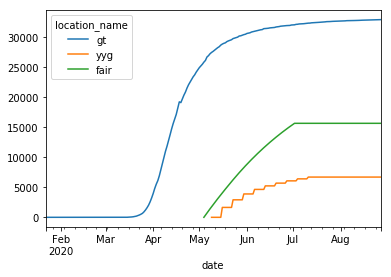

In [136]:
state = 'New York'
# state = 'New Jersey'
# state = 'Massachusetts'
plot_df = gt[[state]].rename(columns={state: 'gt'})
plot_df['yyg'] = fcst[state]
plot_df['fair'] = fair_fcst[state]
plot_df = plot_df.fillna(method='ffill')
plot_df.plot()

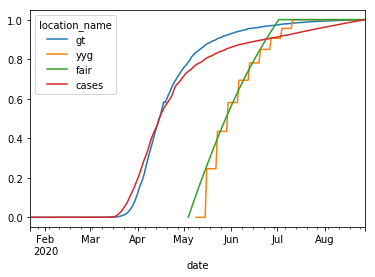

In [137]:
state = 'New York'
# state = 'New Jersey'
# state = 'Massachusetts'
def normalize(x):
    minimum = x.min()
    x -= minimum
    return x / x.max()

plot_df = normalize(gt[[state]].rename(columns={state: 'gt'}))
plot_df['yyg'] = normalize(fcst[state])
plot_df['fair'] = normalize(fair_fcst[state])
plot_df['cases'] = normalize(cases[state])
plot_df = plot_df.fillna(method='ffill')
plot_df.plot()

In [ ]:
plot_df['yyg'][~plot_df['yyg'].isnull()]

In [ ]:
# fcst[state]
gt.loc[pandas.date_range('2020-05-08', '2020-05-30'), state].diff()

In [ ]:
fcst[state].diff()